In [51]:
################################################################################
########    Classification: Decission Trees - Random Forest - Gradient Boosting    ##########
################################################################################
### Load necessary modules -------------------------------
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import sklearn.metrics as mtrs
# Multicolor line
import matplotlib.collections 

from sklearn.calibration import calibration_curve
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

from sklearn import preprocessing
import math
import ClassificationTools as CT
from statsmodels.stats import contingency_tables as cont_tab
from scipy.stats import binom_test
import warnings

In [52]:
### Load file --------------------------------------------
df = pd.read_csv('Simdata.dat', sep = "\t")
df.head()

X1        X2    Y
0 -3.745291  3.729409   NO
1  5.806532 -4.703332  YES
2  4.209833 -0.493488  YES
3  3.429156 -2.307669   NO
4 -0.195014  2.680303   NO

In [53]:
### Convert output variable to factor
df.Y = df.Y.astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   X1      1000 non-null   float64 
 1   X2      1000 non-null   float64 
 2   Y       1000 non-null   category
dtypes: category(1), float64(2)
memory usage: 16.8 KB


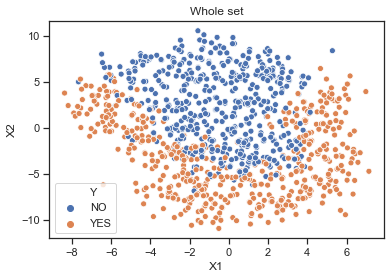

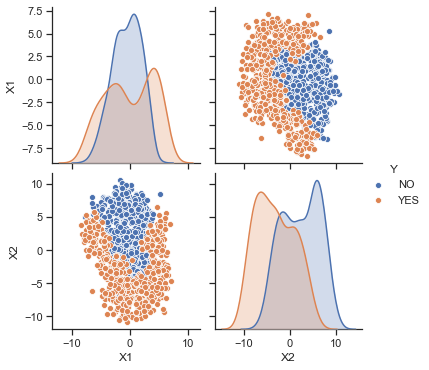

In [54]:
### Exploratory analysis -------------------------------------------------------------------------------------
sns.scatterplot(x = 'X1', y = 'X2', hue = 'Y', data = df).set_title("Whole set")
plt.show()
sns.pairplot(df, hue = 'Y')
plt.show()

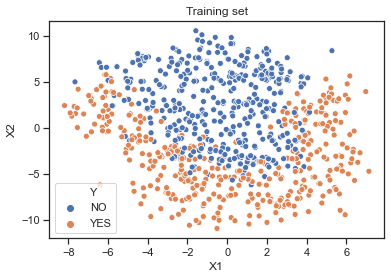

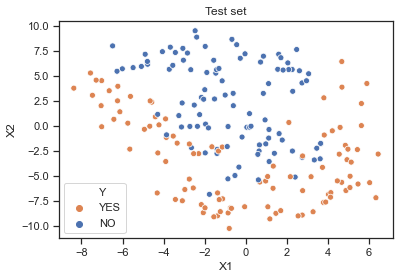

In [55]:
X = df[['X1','X2']]
y = df['Y']
## Divide the data into training and test sets ---------------------------------------------------
## Create random 80/20 % split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 5, stratify = y)

## Create dataset to store model predictions
dfTR_eval = X_train.copy()
dfTR_eval['Y'] = y_train
dfTS_eval = X_test.copy()
dfTS_eval['Y'] = y_test

## plot training and test sets. 
## Try changing the value inside set.seed(). How does it affect the selected data?
palette = {'NO':'C0', 'YES':'C1'} # Needed to maintain color palette 
sns.scatterplot(x = 'X1', y = 'X2', hue = 'Y', data = dfTR_eval, palette=palette).set_title("Training set")
plt.show()
plt.figure() # Needed to plot two separated plots instead of two overlapped
sns.scatterplot(x = 'X1', y = 'X2', hue = 'Y', data = dfTS_eval, palette=palette).set_title("Test set")
plt.show()



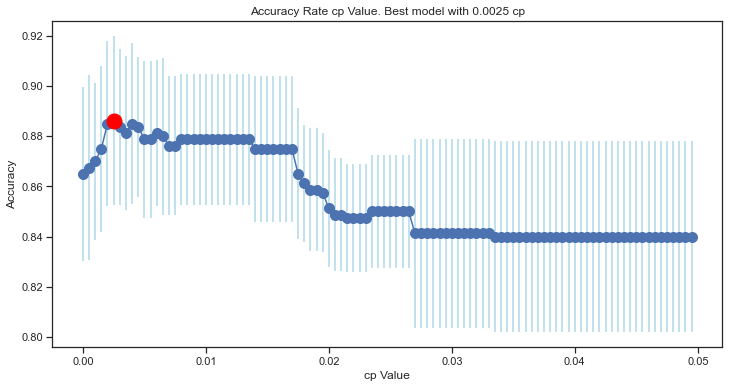

In [56]:
#-------------------------------------------------------------------------------------------------
#---------------------------- DECISION TREE MODEL ------------------------------------------------
#-------------------------------------------------------------------------------------------------
param = {'DT__min_impurity_decrease': np.arange(0,0.05,0.0005)} # Minimum entropy to decrease in each split
pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('DT', DecisionTreeClassifier(criterion='gini',  # impuriry measure
                                                     min_samples_split=5, # Minimum number of obs in node to keep cutting
                                                     min_samples_leaf=5, # Minimum number of obs in a terminal node
                                                     random_state=150))]) # For replication

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
tree_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
tree_fit.fit(X_train, y_train) # Search in grid

# Plot the cross validation score (accuracy) in the Grid Search
nFolds = 10
cv_errors = np.empty([nFolds,len(tree_fit.cv_results_['split0_test_score'])])
for split in range(nFolds):
    cv_errors[split,:] = tree_fit.cv_results_['split' + str(split) + '_test_score']
meanAcc = cv_errors.mean(0)
stdAcc = cv_errors.std(0)

scores_tree = meanAcc # Store cv-scores for later

plt.figure(figsize=(12, 6))
plt.plot(tree_fit.cv_results_['param_DT__min_impurity_decrease'], meanAcc, marker='o', markersize=10)
plt.errorbar(tree_fit.cv_results_['param_DT__min_impurity_decrease'], meanAcc, yerr=stdAcc, linestyle="None", ecolor='lightblue')
plt.plot(tree_fit.best_params_['DT__min_impurity_decrease'], tree_fit.best_score_,marker='o', markersize=15, color='red')
plt.title('Accuracy Rate cp Value. Best model with ' + str(tree_fit.best_params_['DT__min_impurity_decrease']) + ' cp')
plt.xlabel('cp Value')
plt.ylabel('Accuracy')
plt.show()


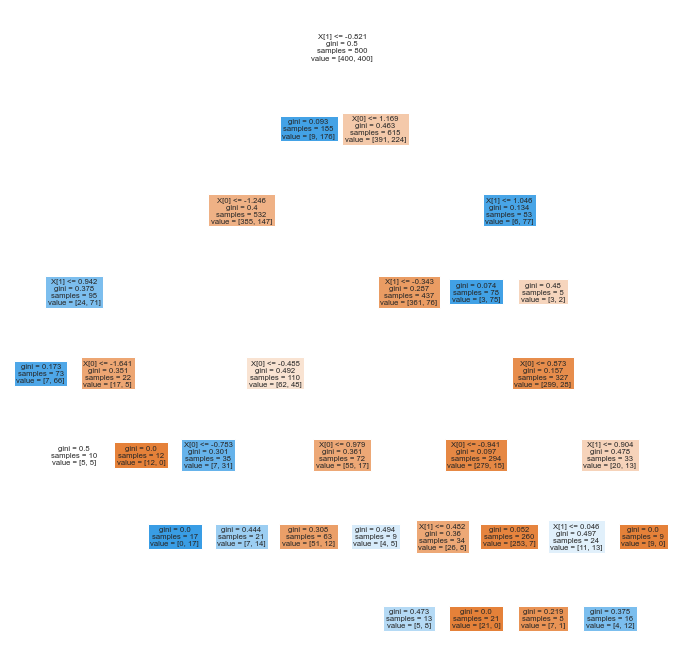

In [57]:
## Plot the decision tree model
plt.figure(figsize=(12, 12))
plot_tree(tree_fit.best_estimator_['DT'], filled=True)
plt.show()

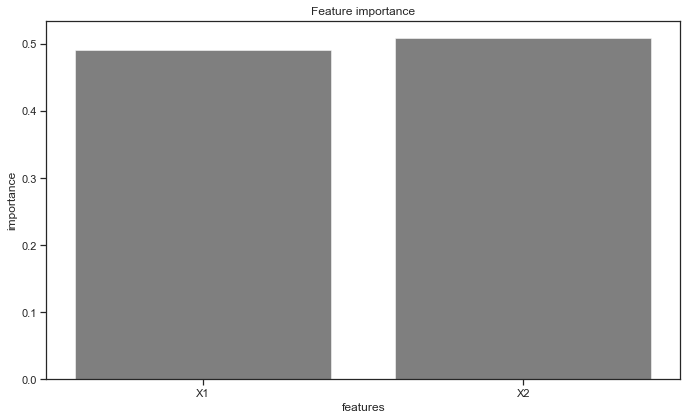

In [58]:
## Plot the variable importance of each feature
plt.figure(figsize=(6 * 1.618, 6))
index = np.arange(len(X_train.columns))
bar_width = 0.35
plt.bar(index, tree_fit.best_estimator_['DT'].feature_importances_, color='black', alpha=0.5)
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Feature importance')
plt.xticks(index, X_train.columns)
plt.tight_layout()
plt.show()

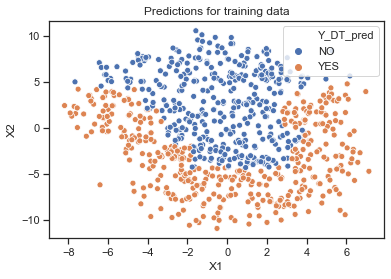

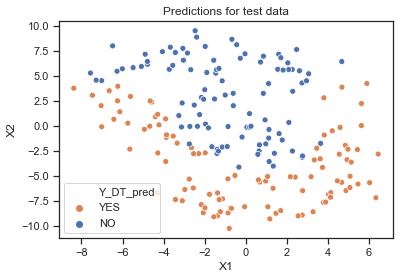

In [59]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_DT_pred'] = tree_fit.predict(X_train)
dfTR_eval['Y_DT_prob_neg'] = tree_fit.predict_proba(X_train)[:,0]
dfTR_eval['Y_DT_prob_pos'] = tree_fit.predict_proba(X_train)[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_DT_pred'] = tree_fit.predict(X_test)
dfTS_eval['Y_DT_prob_neg'] = tree_fit.predict_proba(X_test)[:,0]
dfTS_eval['Y_DT_prob_pos'] = tree_fit.predict_proba(X_test)[:,1]

### Plot predictions of the model
palette = {'NO':'C0', 'YES':'C1'} # Needed to maintain color palette 
sns.scatterplot(x='X1', y='X2', hue='Y_DT_pred', data=dfTR_eval, palette=palette).set_title('Predictions for training data')
plt.show()
plt.figure() # Needed to plot two separated plots instead of two overlapped
sns.scatterplot(x='X1', y='X2', hue='Y_DT_pred', data=dfTS_eval, palette=palette).set_title('Predictions for test data')
plt.show()


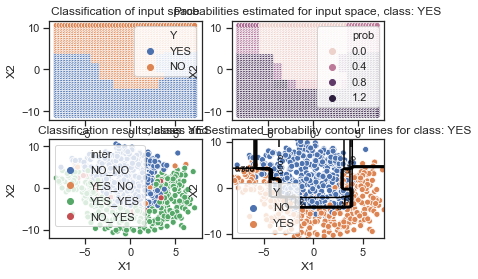

In [60]:
### Plot classification in a 2 dimensional space
CT.plot2DClass(X_train, dfTR_eval['Y'], tree_fit, 'X1', 'X2', 'YES', 50) 

In [61]:
CT.confusion_matrix(dfTR_eval['Y'], dfTR_eval['Y_DT_pred'])


Confusion Matrix and Statistics
	   Prediction
Reference   NO  YES
       NO  361   39
      YES   27  373

Accuracy: 0.92
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.84
Mcnemar's Test P-Value: 0.18
Sensitivity: 0.93
Specificity: 0.9
Pos pred value: 0.91
Neg pred value: 0.93
Prevalence: 0.5
Detection Rate: 0.47
Detection prevalence: 0.52
Balanced accuracy: 0.92
F Score: 0.92
Positive class: YES


In [62]:
CT.confusion_matrix(dfTS_eval['Y'], dfTS_eval['Y_DT_pred'])

Confusion Matrix and Statistics
	   Prediction
Reference  YES  NO
      YES   89  11
       NO   12  88

Accuracy: 0.88
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.77
Mcnemar's Test P-Value: 1.0
Sensitivity: 0.88
Specificity: 0.89
Pos pred value: 0.89
Neg pred value: 0.88
Prevalence: 0.5
Detection Rate: 0.44
Detection prevalence: 0.5
Balanced accuracy: 0.88
F Score: 0.88
Positive class: NO


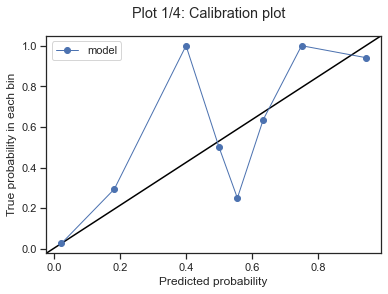

No handles with labels found to put in legend.


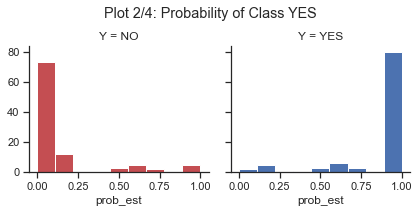

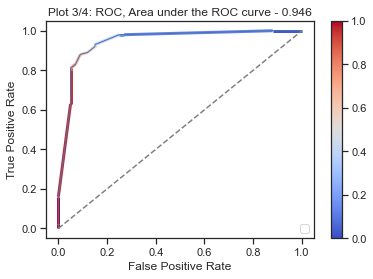

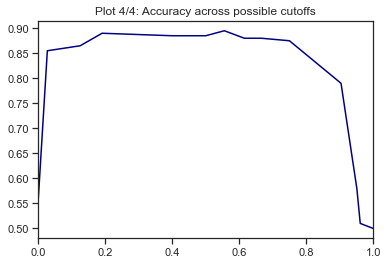

In [63]:
CT.plotClassPerformance(dfTS_eval['Y'], tree_fit.predict_proba(X_test)[:,1], selClass='YES')

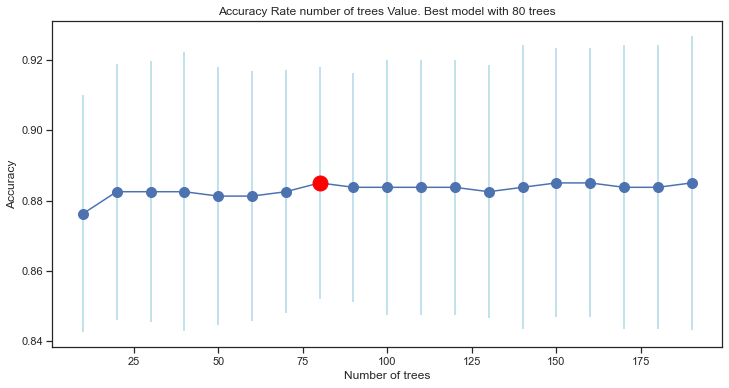

In [64]:
#-------------------------------------------------------------------------------------------------
#---------------------------- RANDOM FOREST MODEL ------------------------------------------------
#-------------------------------------------------------------------------------------------------
param = {'RF__n_estimators': range(10, 200, 10)} #Number of trees to grow
pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('RF', RandomForestClassifier(criterion='gini', # impuriry measure
                                                  max_features=len(X_train.columns),  # number of variables randomly sampled as candidates at each split.
                                                  min_samples_split=5,  # Minimum number of obs in node to keep cutting
                                                  min_samples_leaf=5, # Minimum number of obs in a terminal node
                                                  random_state=150))]) # For replication

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
rf_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
rf_fit.fit(X_train, y_train) # Search in grid

# Plot the cross validation score (accuracy) in the Grid Search
nFolds = 10
cv_errors = np.empty([nFolds,len(rf_fit.cv_results_['split0_test_score'])])
for split in range(nFolds):
    cv_errors[split,:] = rf_fit.cv_results_['split' + str(split) + '_test_score']
meanAcc = cv_errors.mean(0)
stdAcc = cv_errors.std(0)

scores_rf = meanAcc # Store cv-scores for later

plt.figure(figsize=(12, 6))
plt.plot(rf_fit.cv_results_['param_RF__n_estimators'], meanAcc, marker='o', markersize=10)
plt.errorbar(rf_fit.cv_results_['param_RF__n_estimators'], meanAcc, yerr=stdAcc, linestyle="None", ecolor='lightblue')
plt.plot(rf_fit.best_params_['RF__n_estimators'], rf_fit.best_score_,marker='o', markersize=15, color='red')
plt.title('Accuracy Rate number of trees Value. Best model with ' + str(rf_fit.best_params_['RF__n_estimators']) + ' trees')
plt.xlabel('Number of trees')
plt.ylabel('Accuracy')
plt.show()

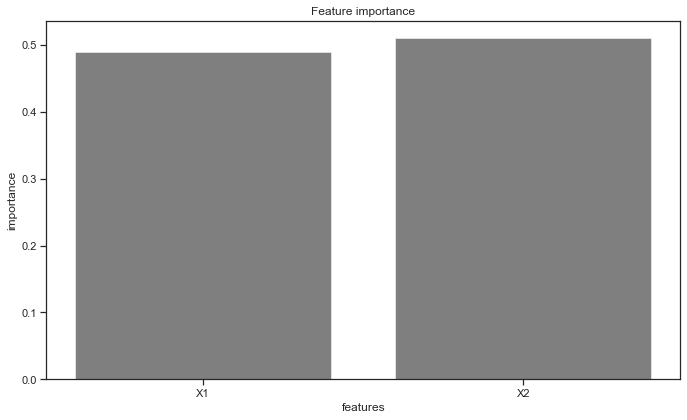

In [65]:
## Plot the variable importance of each feature
plt.figure(figsize=(6 * 1.618, 6))
index = np.arange(len(X_train.columns))
bar_width = 0.35
plt.bar(index, rf_fit.best_estimator_['RF'].feature_importances_, color='black', alpha=0.5)
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Feature importance')
plt.xticks(index, X_train.columns)
plt.tight_layout()
plt.show()

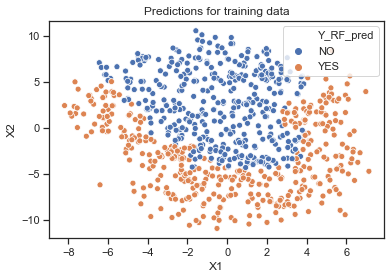

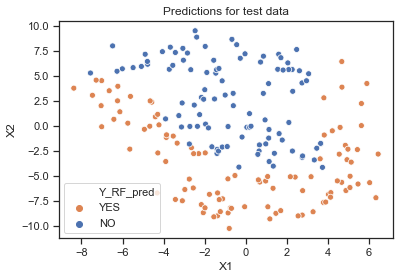

In [66]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_RF_pred'] = rf_fit.predict(X_train)
dfTR_eval['Y_RF_prob_neg'] = rf_fit.predict_proba(X_train)[:,0]
dfTR_eval['Y_RF_prob_pos'] = rf_fit.predict_proba(X_train)[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_RF_pred'] = rf_fit.predict(X_test)
dfTS_eval['Y_RF_prob_neg'] = rf_fit.predict_proba(X_test)[:,0]
dfTS_eval['Y_RF_prob_pos'] = rf_fit.predict_proba(X_test)[:,1]

### Plot predictions of the model
palette = {'NO':'C0', 'YES':'C1'} # Needed to maintain color palette 
sns.scatterplot(x='X1', y='X2', hue='Y_RF_pred', data=dfTR_eval, palette=palette).set_title('Predictions for training data')
plt.show()
plt.figure() # Needed to plot two separated plots instead of two overlapped
sns.scatterplot(x='X1', y='X2', hue='Y_RF_pred', data=dfTS_eval, palette=palette).set_title('Predictions for test data')
plt.show()

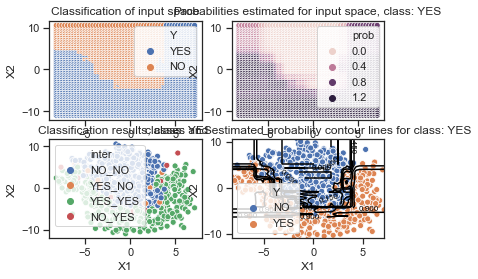

In [67]:
### Plot classification in a 2 dimensional space
CT.plot2DClass(X_train, dfTR_eval['Y'], rf_fit, 'X1', 'X2', 'YES', 50) 

In [68]:
CT.confusion_matrix(dfTR_eval['Y'], dfTR_eval['Y_RF_pred'])

Confusion Matrix and Statistics
	   Prediction
Reference   NO  YES
       NO  372   28
      YES   27  373

Accuracy: 0.93
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.86
Mcnemar's Test P-Value: 1.0
Sensitivity: 0.93
Specificity: 0.93
Pos pred value: 0.93
Neg pred value: 0.93
Prevalence: 0.5
Detection Rate: 0.47
Detection prevalence: 0.5
Balanced accuracy: 0.93
F Score: 0.93
Positive class: YES


In [69]:
CT.confusion_matrix(dfTS_eval['Y'], dfTS_eval['Y_RF_pred'])

Confusion Matrix and Statistics
	   Prediction
Reference  YES  NO
      YES   90  10
       NO   10  90

Accuracy: 0.9
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.8
Mcnemar's Test P-Value: 1.0
Sensitivity: 0.9
Specificity: 0.9
Pos pred value: 0.9
Neg pred value: 0.9
Prevalence: 0.5
Detection Rate: 0.45
Detection prevalence: 0.5
Balanced accuracy: 0.9
F Score: 0.9
Positive class: NO


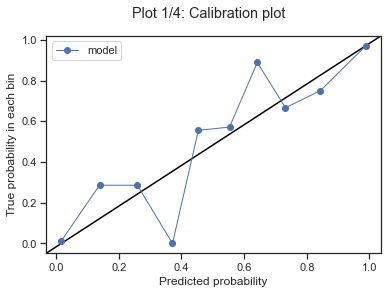

No handles with labels found to put in legend.


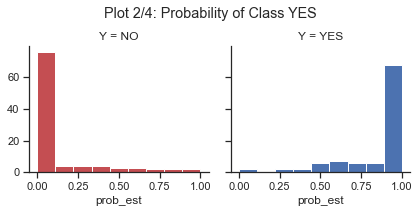

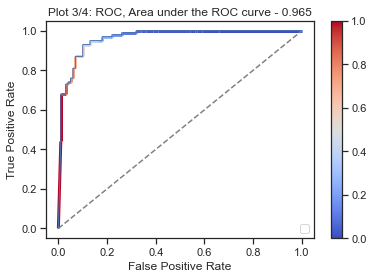

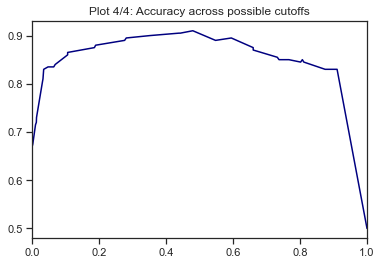

In [70]:
CT.plotClassPerformance(dfTS_eval['Y'], rf_fit.predict_proba(X_test)[:,1], selClass='YES')

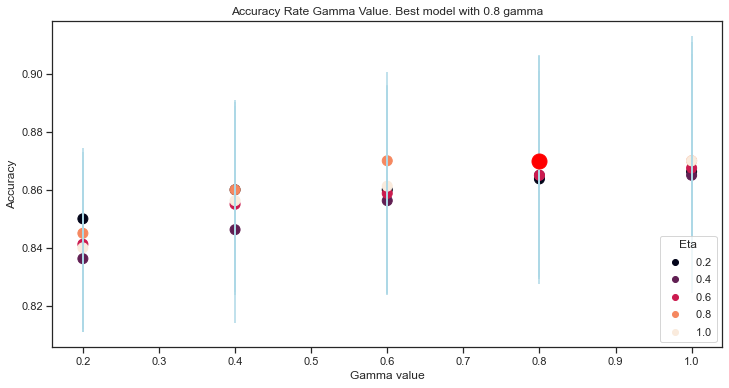

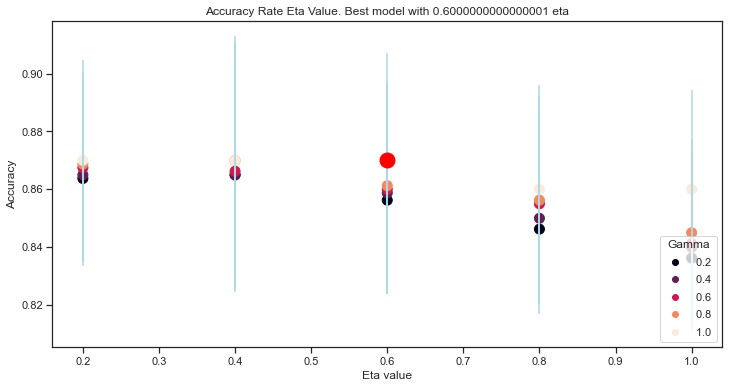

In [71]:
#-------------------------------------------------------------------------------------------------
#---------------------------------- XGBOOST MODEL ------------------------------------------------
#-------------------------------------------------------------------------------------------------
## Train model -----------------------------------------------------------------------------------
# Define the grid of parameters to search if several parameters have to be varied
# All the parameters that can remain constant can be used inside XGBClassifier()
param = {'xgb__max_depth': [5],#[5, 3, 1], #Max Tree Depth
         'xgb__eta': np.arange(0.2, 1.2, 0.2), #np.arange(0.0, 1, 0.2), #Shrinkage
         'xgb__gamma': np.arange(0.2, 1.2, 0.2), #np.arange(0.0, 1, 0.2), #Minimum Loss Reduction
         'xgb__min_child_weight': [3], #[5, 3, 1], #Minimum Sum of Instance Weight
         'xgb__subsample': [0.2],#np.arange(0, 1, 0.2), #Subsample percentage
         'xgb__colsample_bytree': [0.2],#np.arange(0, 1, 0.2), #Subsample Ratio of Columns
         'xgb__booster': ['gbtree'], #Choose booster
         'xgb__seed': [150], #For replication
         'xgb__objective': ['binary:logistic']}
pipe = Pipeline(steps=[('scaler', StandardScaler()), ('xgb', XGBClassifier(random_state=150))])

xgb_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
xgb_fit.fit(X_train, y_train)

# Plot the cross validation score (accuracy) in the Grid Search
nFolds = 10
cv_errors = np.empty([nFolds,len(xgb_fit.cv_results_['split0_test_score'])])
for split in range(nFolds):
    cv_errors[split,:] = xgb_fit.cv_results_['split' + str(split) + '_test_score']
meanAcc = cv_errors.mean(0)
stdAcc = cv_errors.std(0)

scores_xgb = meanAcc # Store cv-scores for later

# Create a plot with each parameters where we want to watch the error
plt.subplots(figsize=(12, 6))
plt.errorbar(xgb_fit.cv_results_['param_xgb__gamma'], 
             [x for _,x in sorted(zip(xgb_fit.cv_results_['param_xgb__gamma'],meanAcc))], 
             yerr=[x for _,x in sorted(zip(xgb_fit.cv_results_['param_xgb__gamma'],stdAcc))], 
             linestyle="None", ecolor='lightblue')
sct = plt.scatter(xgb_fit.cv_results_['param_xgb__gamma'], 
            [x for _,x in sorted(zip(xgb_fit.cv_results_['param_xgb__gamma'],meanAcc))], 
            c=np.array(xgb_fit.cv_results_['param_xgb__eta'], dtype=float),s=100)
plt.legend(*sct.legend_elements(), loc="lower right", title="Eta")
plt.plot(xgb_fit.best_params_['xgb__gamma'], xgb_fit.best_score_,marker='o', markersize=15, color='red')
plt.title('Accuracy Rate Gamma Value. Best model with ' + str(xgb_fit.best_params_['xgb__gamma']) + ' gamma')
plt.xlabel('Gamma value')
plt.ylabel('Accuracy')
plt.show()

plt.subplots(figsize=(12, 6))
plt.errorbar(xgb_fit.cv_results_['param_xgb__eta'], 
             [x for _,x in sorted(zip(xgb_fit.cv_results_['param_xgb__eta'],meanAcc))], 
             yerr=[x for _,x in sorted(zip(xgb_fit.cv_results_['param_xgb__eta'],stdAcc))], 
             linestyle="None", ecolor='lightblue')
sct = plt.scatter(xgb_fit.cv_results_['param_xgb__eta'], 
            [x for _,x in sorted(zip(xgb_fit.cv_results_['param_xgb__eta'],meanAcc))], 
            c=np.array(xgb_fit.cv_results_['param_xgb__gamma'], dtype=float),s=100)
plt.legend(*sct.legend_elements(), loc="lower right", title="Gamma")
plt.plot(xgb_fit.best_params_['xgb__eta'], xgb_fit.best_score_,marker='o', markersize=15, color='red')
plt.title('Accuracy Rate Eta Value. Best model with ' + str(xgb_fit.best_params_['xgb__eta']) + ' eta')
plt.xlabel('Eta value')
plt.ylabel('Accuracy')
plt.show()

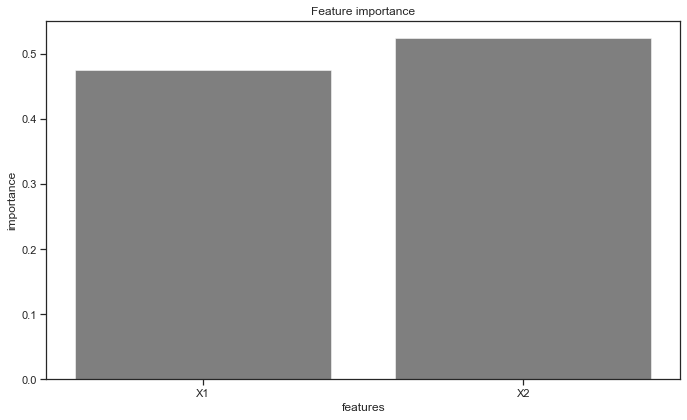

In [72]:
## Plot the variable importance of each feature
plt.figure(figsize=(6 * 1.618, 6))
index = np.arange(len(X_train.columns))
bar_width = 0.35
plt.bar(index, xgb_fit.best_estimator_['xgb'].feature_importances_, color='black', alpha=0.5)
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Feature importance')
plt.xticks(index, X_train.columns)
plt.tight_layout()
plt.show()

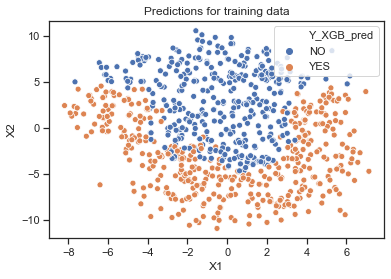

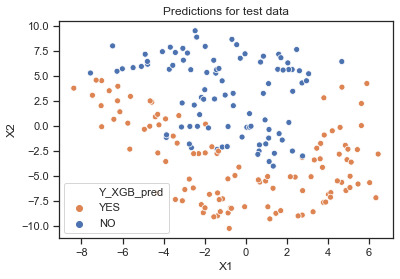

In [73]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_XGB_pred'] = xgb_fit.predict(X_train)
dfTR_eval['Y_XGB_prob_neg'] = xgb_fit.predict_proba(X_train)[:,0]
dfTR_eval['Y_XGB_prob_pos'] = xgb_fit.predict_proba(X_train)[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_XGB_pred'] = xgb_fit.predict(X_test)
dfTS_eval['Y_XGB_prob_neg'] = xgb_fit.predict_proba(X_test)[:,0]
dfTS_eval['Y_XGB_prob_pos'] = xgb_fit.predict_proba(X_test)[:,1]

### Plot predictions of the model
palette = {'NO':'C0', 'YES':'C1'} # Needed to maintain color palette 
sns.scatterplot(x='X1', y='X2', hue='Y_XGB_pred', data=dfTR_eval, palette=palette).set_title('Predictions for training data')
plt.show()
plt.figure() # Needed to plot two separated plots instead of two overlapped
sns.scatterplot(x='X1', y='X2', hue='Y_XGB_pred', data=dfTS_eval, palette=palette).set_title('Predictions for test data')
plt.show()

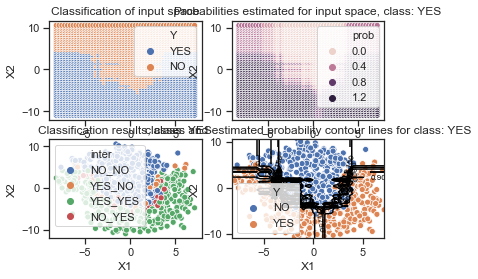

In [74]:
### Plot classification in a 2 dimensional space
CT.plot2DClass(X_train, dfTR_eval['Y'], xgb_fit, 'X1', 'X2', 'YES', 50) 

In [75]:
CT.confusion_matrix(dfTR_eval['Y'], dfTR_eval['Y_XGB_pred'])

Confusion Matrix and Statistics
	   Prediction
Reference   NO  YES
       NO  348   52
      YES   32  368

Accuracy: 0.9
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.79
Mcnemar's Test P-Value: 0.04
Sensitivity: 0.92
Specificity: 0.87
Pos pred value: 0.88
Neg pred value: 0.92
Prevalence: 0.5
Detection Rate: 0.46
Detection prevalence: 0.52
Balanced accuracy: 0.9
F Score: 0.9
Positive class: YES


In [76]:
CT.confusion_matrix(dfTS_eval['Y'], dfTS_eval['Y_XGB_pred'])

Confusion Matrix and Statistics
	   Prediction
Reference  YES  NO
      YES   92   8
       NO   17  83

Accuracy: 0.88
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.75
Mcnemar's Test P-Value: 0.11
Sensitivity: 0.83
Specificity: 0.92
Pos pred value: 0.91
Neg pred value: 0.84
Prevalence: 0.5
Detection Rate: 0.42
Detection prevalence: 0.46
Balanced accuracy: 0.88
F Score: 0.87
Positive class: NO


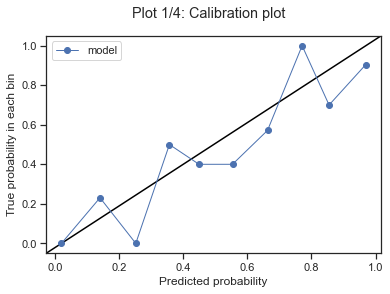

No handles with labels found to put in legend.


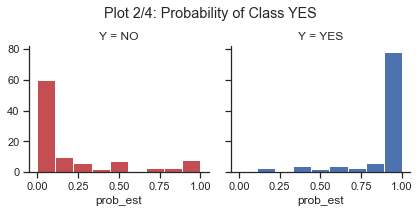

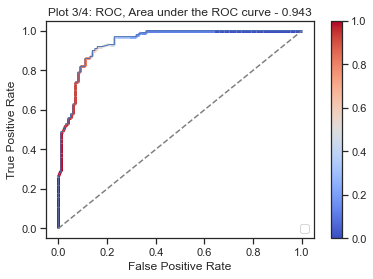

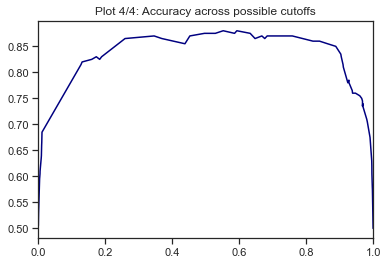

In [77]:
CT.plotClassPerformance(dfTS_eval['Y'], xgb_fit.predict_proba(X_test)[:,1], selClass='YES')

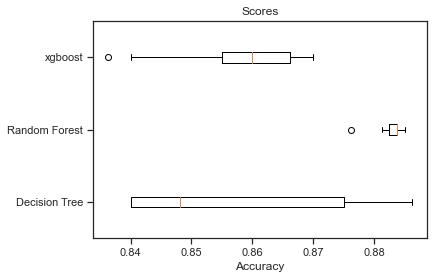

In [78]:
## Compare models
metric = 'Accuracy'
score = {'Decision Tree': scores_tree, 'Random Forest': scores_rf, 'xgboost': scores_xgb}
CT.dotplot(score, metric)

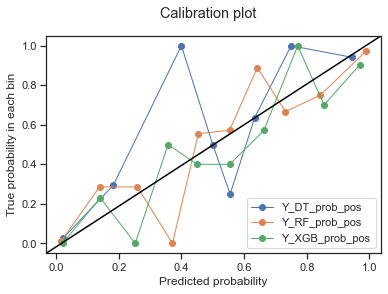

In [79]:
CT.calibration_plot(y_test, dfTS_eval[['Y_DT_prob_pos','Y_RF_prob_pos','Y_XGB_prob_pos']])

Area under the ROC curve of Y_DT_prob_pos : 0.946
Area under the ROC curve of Y_RF_prob_pos : 0.965
Area under the ROC curve of Y_XGB_prob_pos : 0.943


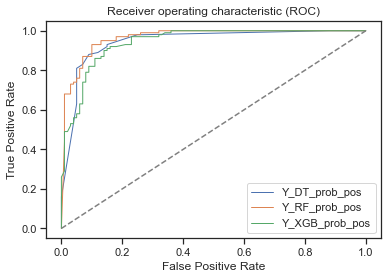

In [80]:
CT.roc_curve(y_test,dfTS_eval[['Y_DT_prob_pos','Y_RF_prob_pos','Y_XGB_prob_pos']], 'YES')